# Capstone Project - The Battle of Neighborhoods (Week 2)

In [81]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from geopy.geocoders import Nominatim
import urllib.request
import json
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    ------------------------------------------------------------
                       

In [92]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Data downloaded!


In [93]:
neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [94]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [95]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [96]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [97]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'ZMHWBS0SR12Z3YDYVHJVTZPRK3U1ZP3I2TYQAJ5CU3JUHMB5' # changed my Foursquare ID
    CLIENT_SECRET = 'H3TT0XT3P5TIAFCV1Y2UUVLF42N44DICNKLUELK34H2TKLFR' # changed Foursquare Secret
    VERSION = '20181020' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [98]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'ZMHWBS0SR12Z3YDYVHJVTZPRK3U1ZP3I2TYQAJ5CU3JUHMB5' # i have changed the id with ##
    CLIENT_SECRET = 'H3TT0XT3P5TIAFCV1Y2UUVLF42N44DICNKLUELK34H2TKLFR' # i have changed the secret with ##
    VERSION = '20181020' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [99]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [100]:
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [101]:
new_york_data.shape

(306, 4)

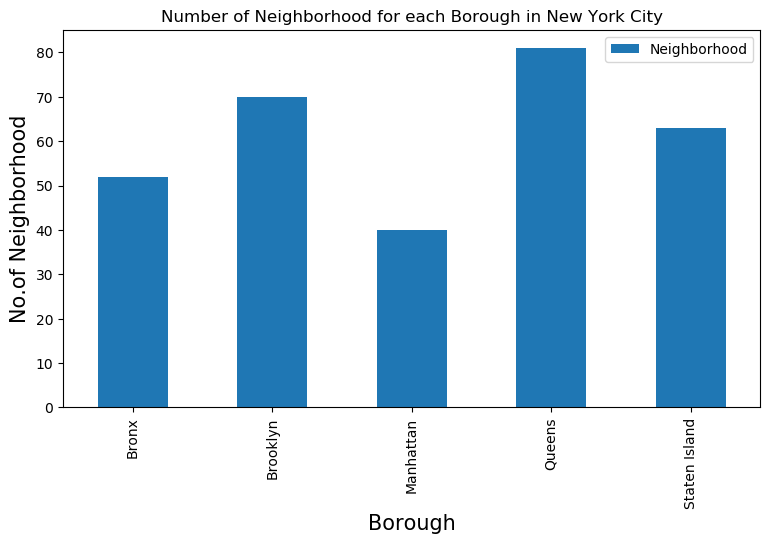

In [102]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has highest number of neighborhoods

Now we will collect Indian resturants for each Neighborhood

In [103]:
# prepare neighborhood list that contains greek resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
greek_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    greek_resturants=venues[venues['Category']=='Greek Restaurant']   
    print('(',count,'/',len(new_york_data),')','Greek Resturants in '+Neighborhood+', '+Borough+':'+str(len(greek_resturants)))
    for resturant_detail in greek_resturants.values.tolist():
        id, name , category=resturant_detail
        greek_rest_ny = greek_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

done
( 1 / 306 ) Greek Resturants in Wakefield, Bronx:0
done
( 2 / 306 ) Greek Resturants in Co-op City, Bronx:0
done
( 3 / 306 ) Greek Resturants in Eastchester, Bronx:0
done
( 4 / 306 ) Greek Resturants in Fieldston, Bronx:1
done
( 5 / 306 ) Greek Resturants in Riverdale, Bronx:1
done
( 6 / 306 ) Greek Resturants in Kingsbridge, Bronx:1
done
( 7 / 306 ) Greek Resturants in Marble Hill, Manhattan:0
done
( 8 / 306 ) Greek Resturants in Woodlawn, Bronx:0
done
( 9 / 306 ) Greek Resturants in Norwood, Bronx:0
done
( 10 / 306 ) Greek Resturants in Williamsbridge, Bronx:0
done
( 11 / 306 ) Greek Resturants in Baychester, Bronx:0
done
( 12 / 306 ) Greek Resturants in Pelham Parkway, Bronx:0
done
( 13 / 306 ) Greek Resturants in City Island, Bronx:0
done
( 14 / 306 ) Greek Resturants in Bedford Park, Bronx:0
done
( 15 / 306 ) Greek Resturants in University Heights, Bronx:0
done
( 16 / 306 ) Greek Resturants in Morris Heights, Bronx:0
done
( 17 / 306 ) Greek Resturants in Fordham, Bronx:0
done

done
( 134 / 306 ) Greek Resturants in Howard Beach, Queens:1
done
( 135 / 306 ) Greek Resturants in Corona, Queens:0
done
( 136 / 306 ) Greek Resturants in Forest Hills, Queens:1
done
( 137 / 306 ) Greek Resturants in Kew Gardens, Queens:0
done
( 138 / 306 ) Greek Resturants in Richmond Hill, Queens:0
done
( 139 / 306 ) Greek Resturants in Flushing, Queens:0
done
( 140 / 306 ) Greek Resturants in Long Island City, Queens:0
done
( 141 / 306 ) Greek Resturants in Sunnyside, Queens:0
done
( 142 / 306 ) Greek Resturants in East Elmhurst, Queens:0
done
( 143 / 306 ) Greek Resturants in Maspeth, Queens:0
done
( 144 / 306 ) Greek Resturants in Ridgewood, Queens:1
done
( 145 / 306 ) Greek Resturants in Glendale, Queens:0
done
( 146 / 306 ) Greek Resturants in Rego Park, Queens:0
done
( 147 / 306 ) Greek Resturants in Woodhaven, Queens:0
done
( 148 / 306 ) Greek Resturants in Ozone Park, Queens:0
done
( 149 / 306 ) Greek Resturants in South Ozone Park, Queens:0
done
( 150 / 306 ) Greek Restura

done
( 263 / 306 ) Greek Resturants in Mill Basin, Brooklyn:0
done
( 264 / 306 ) Greek Resturants in Jamaica Hills, Queens:0
done
( 265 / 306 ) Greek Resturants in Utopia, Queens:0
done
( 266 / 306 ) Greek Resturants in Pomonok, Queens:0
done
( 267 / 306 ) Greek Resturants in Astoria Heights, Queens:2
done
( 268 / 306 ) Greek Resturants in Claremont Village, Bronx:0
done
( 269 / 306 ) Greek Resturants in Concourse Village, Bronx:0
done
( 270 / 306 ) Greek Resturants in Mount Eden, Bronx:0
done
( 271 / 306 ) Greek Resturants in Mount Hope, Bronx:0
done
( 272 / 306 ) Greek Resturants in Sutton Place, Manhattan:1
done
( 273 / 306 ) Greek Resturants in Hunters Point, Queens:0
done
( 274 / 306 ) Greek Resturants in Turtle Bay, Manhattan:2
done
( 275 / 306 ) Greek Resturants in Tudor City, Manhattan:1
done
( 276 / 306 ) Greek Resturants in Stuyvesant Town, Manhattan:2
done
( 277 / 306 ) Greek Resturants in Flatiron, Manhattan:0
done
( 278 / 306 ) Greek Resturants in Sunnyside Gardens, Queens

In [105]:
greek_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Fieldston,4bc39d1d2a89ef3bdf49f588,Greek Express
1,Bronx,Riverdale,4bc39d1d2a89ef3bdf49f588,Greek Express
2,Bronx,Kingsbridge,4bc39d1d2a89ef3bdf49f588,Greek Express
3,Brooklyn,Bay Ridge,4bbce66da0a0c9b6b9f41a0f,Elia Restaurant
4,Brooklyn,Bay Ridge,58fa85be98fbfc397bafe21f,Blue Door Souvlakia


In [104]:
greek_rest_ny.shape

(79, 4)

We got 79 Greek Resturants across New York City

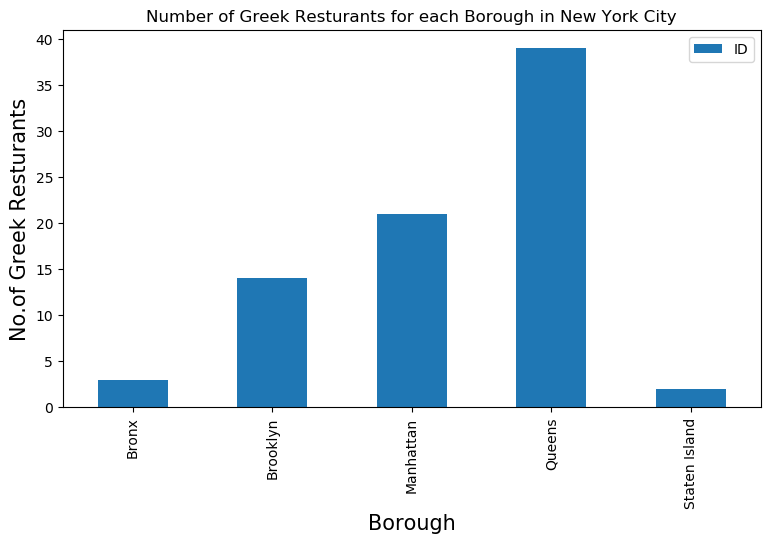

In [106]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Greek Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Greek Resturants', fontsize=15)
#giving a bar plot
greek_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has the largest number of Greek resturants

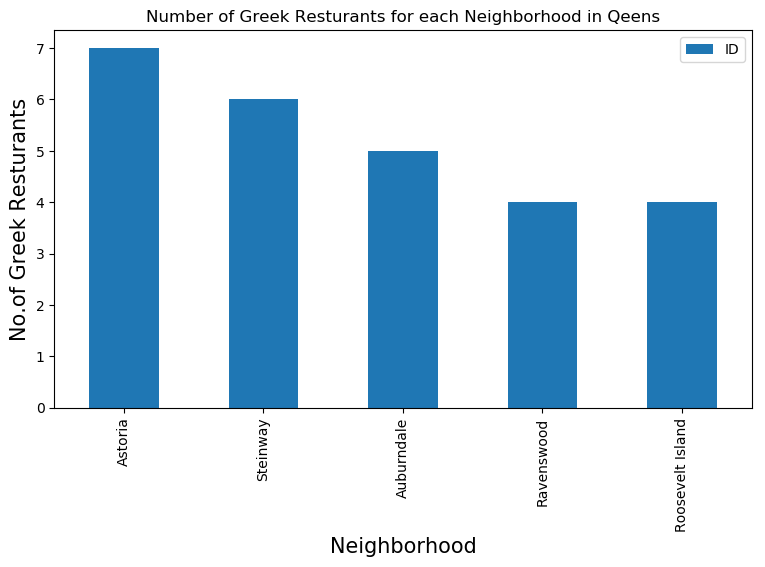

In [107]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Greek Resturants for each Neighborhood in Qeens')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Greek Resturants', fontsize=15)
#giving a bar plot
greek_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [108]:
greek_rest_ny[greek_rest_ny['Neighborhood']=='Astoria']

,Borough,Neighborhood,ID,Name
31,Queens,Astoria,553ffa91498e2c76f06c0c03,SVL Bar
32,Queens,Astoria,4a7b0eb5f964a520e5e91fe3,BZ Grill
33,Queens,Astoria,59f3b0a2dee770670b00c0a1,Gyro World
34,Queens,Astoria,4b0b36a5f964a520cb2e23e3,Gyro Uno
35,Queens,Astoria,4aa840a9f964a520665020e3,Ovelia Psistaria Bar
36,Queens,Astoria,4a9b2269f964a520863420e3,Stamatis
37,Queens,Astoria,48a7dcf0f964a520a0511fe3,Telly's Taverna


So Astoria in Queens has the highest number of Greek Resturants with a total count of 7.

Now we will get the ranking of each resturant for further analysis.

In [109]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
greek_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in greek_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(greek_rest_ny),')','processed')
    greek_rest_stats_ny = greek_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID           Name  Likes  Rating  Tips
0  4bc39d1d2a89ef3bdf49f588  Greek Express     33     8.0    16
( 1 / 79 ) processed
                         ID           Name  Likes  Rating  Tips
0  4bc39d1d2a89ef3bdf49f588  Greek Express     33     8.0    16
( 2 / 79 ) processed
                         ID           Name  Likes  Rating  Tips
0  4bc39d1d2a89ef3bdf49f588  Greek Express     33     8.0    16
( 3 / 79 ) processed
                         ID             Name  Likes  Rating  Tips
0  4bbce66da0a0c9b6b9f41a0f  Elia Restaurant     10     7.8    12
( 4 / 79 ) processed
                         ID                 Name  Likes  Rating  Tips
0  58fa85be98fbfc397bafe21f  Blue Door Souvlakia      8     7.2     6
( 5 / 79 ) processed
                         ID             Name  Likes  Rating  Tips
0  4bca37a60687ef3b1a96dbcc  Something Greek     26     7.7    15
( 6 / 79 ) processed
                         ID    Name  Likes  Rating  Tips
0  4bdc6a0d3904a593f7104e9e  

                         ID                   Name  Likes  Rating  Tips
0  4a5a425df964a52003ba1fe3  Zorba's Souvlaki Plus     26     7.7    15
( 56 / 79 ) processed
                         ID                 Name  Likes  Rating  Tips
0  561a965b498e99e2d7512565  Dionysos Restaurant      7     7.5     5
( 57 / 79 ) processed
                         ID         Name  Likes  Rating  Tips
0  4be211e01dd22d7f584993bd  Tasty Grill     26     8.0    19
( 58 / 79 ) processed
                         ID               Name  Likes  Rating  Tips
0  4b52664df964a5205d7b27e3  Bahari Estiatorio    199     8.7    70
( 59 / 79 ) processed
                         ID               Name  Likes  Rating  Tips
0  4a90aa10f964a520071920e3  Aliada Restaurant     58     8.1    31
( 60 / 79 ) processed
                         ID            Name  Likes  Rating  Tips
0  5c3a736942d8c2002c3258af  Amylos Taverna      7     8.3     4
( 61 / 79 ) processed
                         ID            Name  Likes  Rating

In [110]:
greek_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Fieldston,4bc39d1d2a89ef3bdf49f588,Greek Express,33,8.0,16
1,Bronx,Riverdale,4bc39d1d2a89ef3bdf49f588,Greek Express,33,8.0,16
2,Bronx,Kingsbridge,4bc39d1d2a89ef3bdf49f588,Greek Express,33,8.0,16
3,Brooklyn,Bay Ridge,4bbce66da0a0c9b6b9f41a0f,Elia Restaurant,10,7.8,12
4,Brooklyn,Bay Ridge,58fa85be98fbfc397bafe21f,Blue Door Souvlakia,8,7.2,6


In [111]:
greek_rest_stats_ny.shape

(79, 7)

In [112]:
greek_rest_ny.shape

(79, 4)

So we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required

In [113]:
greek_rest_stats_ny.to_csv('greek_rest_stats_ny.csv', index=False)

In [116]:
greek_rest_stats_ny_csv.shape

NameError: name 'greek_rest_stats_ny_csv' is not defined

In [124]:
greek_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Fieldston,4bc39d1d2a89ef3bdf49f588,Greek Express,33.0,8.0,16.0
1,Bronx,Riverdale,4bc39d1d2a89ef3bdf49f588,Greek Express,33.0,8.0,16.0
2,Bronx,Kingsbridge,4bc39d1d2a89ef3bdf49f588,Greek Express,33.0,8.0,16.0
3,Brooklyn,Bay Ridge,4bbce66da0a0c9b6b9f41a0f,Elia Restaurant,10.0,7.8,12.0
4,Brooklyn,Bay Ridge,58fa85be98fbfc397bafe21f,Blue Door Souvlakia,8.0,7.2,6.0


In [125]:
greek_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 7 columns):
Borough         79 non-null object
Neighborhood    79 non-null object
ID              79 non-null object
Name            79 non-null object
Likes           79 non-null float64
Rating          79 non-null float64
Tips            79 non-null float64
dtypes: float64(3), object(4)
memory usage: 4.4+ KB



We see that values like Likes, Tips are strig values. We would need to convert them into float for further analysis

In [126]:
greek_rest_stats_ny['Likes']=greek_rest_stats_ny['Likes'].astype('float64')
greek_rest_stats_ny['Tips']=greek_rest_stats_ny['Tips'].astype('float64')

In [127]:
greek_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 7 columns):
Borough         79 non-null object
Neighborhood    79 non-null object
ID              79 non-null object
Name            79 non-null object
Likes           79 non-null float64
Rating          79 non-null float64
Tips            79 non-null float64
dtypes: float64(3), object(4)
memory usage: 4.4+ KB


In [128]:
# Resturant with maximum Likes
greek_rest_stats_ny.iloc[greek_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                   Chinatown
ID              5521c2ff498ebe2368634187
Name                              Kiki's
Likes                                825
Rating                               9.1
Tips                                 204
Name: 17, dtype: object

In [129]:
# Resturant with maximum Rating
greek_rest_stats_ny.iloc[greek_rest_stats_ny['Rating'].idxmax()]

Borough                           Queens
Neighborhood                    Steinway
ID              4b491ca9f964a520586626e3
Name                    Loukoumi Taverna
Likes                                 98
Rating                               9.2
Tips                                  42
Name: 51, dtype: object

In [130]:
# Resturant with maximum Tips
greek_rest_stats_ny.iloc[greek_rest_stats_ny['Tips'].idxmax()]

Borough                           Queens
Neighborhood                    Steinway
ID              4a8e20edf964a520131220e3
Name                    Taverna Kyclades
Likes                                631
Rating                                 9
Tips                                 284
Name: 52, dtype: object

In [131]:
ny_neighborhood_stats=greek_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [132]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
8,Chinatown,9.10
18,Gramercy,9.00
12,East Village,9.00
39,Stuyvesant Town,8.95
29,Noho,8.80
25,Lower East Side,8.80
7,Carroll Gardens,8.80
17,Gowanus,8.70
4,Bayside,8.65
41,Tribeca,8.65


Above are the top neighborhoods with top average rating of Greek resturant

In [133]:
ny_borough_stats=greek_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [134]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.614286
0,Bronx,8.000000
1,Brooklyn,7.800000
3,Queens,7.612821
4,Staten Island,0.000000



Similarly these are the average rating of Greek Resturants for each Borough

Lets visualize it

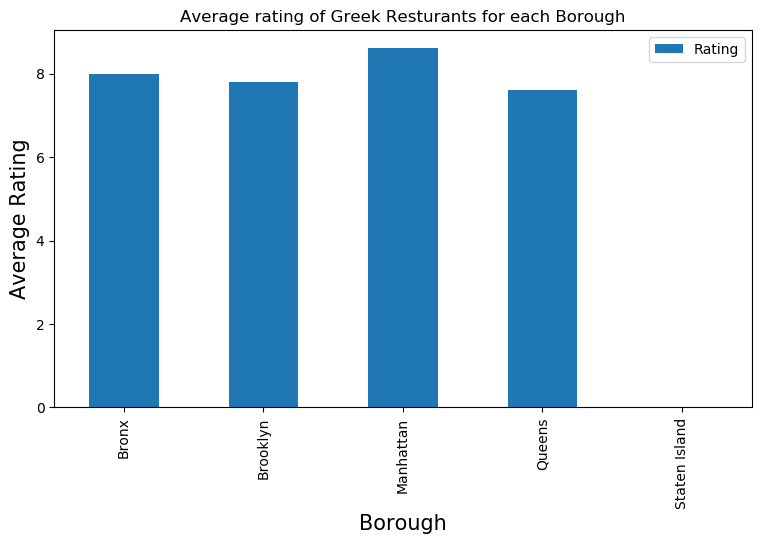

In [136]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Greek Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
greek_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 8.8 to visualize on map

In [138]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.8]

ny_neighborhood_stats

,Neighborhood,Average Rating
7,Carroll Gardens,8.80
8,Chinatown,9.10
12,East Village,9.00
18,Gramercy,9.00
25,Lower East Side,8.80
29,Noho,8.80
39,Stuyvesant Town,8.95


We will join this dataset to original new york data to get lonitude and latitude

In [139]:

ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Carroll Gardens,40.680540,-73.994654,8.80
1,Manhattan,Chinatown,40.715618,-73.994279,9.10
2,Manhattan,East Village,40.727847,-73.982226,9.00
3,Manhattan,Gramercy,40.737210,-73.981376,9.00
4,Manhattan,Lower East Side,40.717807,-73.980890,8.80
5,Manhattan,Noho,40.723259,-73.988434,8.80
6,Manhattan,Stuyvesant Town,40.731000,-73.974052,8.95



Now we will show this data on a map

In [142]:
# create map and display it
ny_map = folium.Map(location=[latitude, longitude], zoom_start=12)

In [143]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [144]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [145]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Conclusion
Chinatown(Manhattan), East Village(Manhattan) and Gramecy(Manhattan) are some of the best neighborhoods for greek cuisine.
Brooklyn has potential for greek Resturant Market
Manhattan is the best place to stay if you prefer greek Cuisine.

### Limitations

The ranking is purely on basis of rating of resturants
The accuracy of data depends purely depends on the data provided by FourSquare